# オープン直後に買ってクローズ直前に売る

### 仮説
1. 上昇する日と下落する日の割合はほぼ五分五分のはずだから、一切のフィルターなしで毎日取引を行えば、損益期待値は手数料とスリッページ分だけ損するはず。ただ、長期で見ると指数の場合は経済の拡大とともに徐々に上がっていくから多少のプラス期待値（手数料とスリッページを引くとマイナスになるとしても）はあるはず。
1. ラリー・ウィリアムズの短期売買法によれば、大きく上がる日ほど始値からあまり下がることなく上がる一方、大きく下がる日は始値からあまり上がることなく下がる。
  - とすれば、損切の逆指値を買値からあまり遠くないところに置いておけば、下がる日には早めに損切ができて、上がる日には持ち続けられる可能性が高い。
  - この損切戦略は損益期待値に正の寄与をするはず。
1. 上がる日でも終値が高値よりかなり安い日もあるはず。
  - トレーリングストップを置けば、こういう日に利益をあまり失わずに済むから、損益期待値に正の寄与をするはず。
  - ただし、上がる日で、いったん上がってそのあと大きく下がり、また上がって高値をつけ、その付近で引けるということが良くあるのだとしたらこの限りではない。
1. 前日までのデータを使って、今日上がるか下がるかを50％より高い確率で予測できるはず。
  - この予測で買いから仕掛けるか売りから仕掛けるかを変えることは、損益期待値に正の寄与をするはず。
1. 十分に利益が出るほどに上がる日は、オープンからあまり時間がたたずにある程度上がるはず。
  - だから、オープンから一定時間後に上がっていなければ**損切の逆指値価格を引き上げるということができれば**、途中で大きく下げて損切に引っかかるときの損失を少なくできる（あわよくばわずかな利益が出る）

### 検証すること
1. 上昇日と下落日がほぼ五分五分であるか
1. また、`上昇価格の総和 - 下落価格の総和 > 0`であるか
1. 大きく上がる日ほど始値からあまり下がらないという傾向があるか
1. 下がる日については逆の傾向があるか
1. 上がる日において、`高値 - 終値`の分布を可視化して、差が大きい日がどの程度あるか確認
1. 上がる日において、いったん大きく上がってから大きく下がり、またさらに大きく上がって高値を付け、その付近で引ける日がどれくらいあるか（日足じゃ無理）
1. 前日までのデータを使って、当日上がるか下がるかをどれくらいの確率で予測できるか（別のテーマとしてしっかり取り組む必要あり）
1. 大きく上がる日ほど、オープンからあまり時間がたたずに上がる傾向があるか

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('./data/N225minif_2020_exchange_daily.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      3377 non-null   object
 1   始値      3377 non-null   int64 
 2   高値      3377 non-null   int64 
 3   安値      3377 non-null   int64 
 4   終値      3377 non-null   int64 
 5   出来高     3377 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 158.4+ KB


In [24]:
df.head()

,日付,始値,高値,安値,終値,出来高,CODiff
0,2006/7/18,14680,14715,14400,14400,22345,-280
1,2006/7/19,14500,14650,14465,14560,20646,60
2,2006/7/20,14860,14975,14780,14975,17398,115
3,2006/7/21,14840,14875,14790,14820,14689,-20
4,2006/7/24,14685,14870,14560,14775,22641,90


# 1. 上昇日と下落日がほぼ五分五分であるか
- 上昇日の方が1.1倍だから少し多い。長期で見ると株式指数は約10％程度の上昇傾向にあるから妥当なところか。
- 始値 == 終値　の日も利益は出ないから、下落日に含めておく。

In [20]:
# 上昇した日（終値＞始値）と下落した日の比率
# ここでは、始値 == 終値　の日は除く
df['CODiff'] = df['終値'] - df['始値'] # Close - Open の Diff
nUpDays = (df['CODiff'] > 0).sum()
nDownDays = (df['CODiff'] < 0).sum()
upDownRatio = nUpDays / nDownDays
print('上昇日：', nUpDays)
print('下落日：', nDownDays)
print('上昇日 / 下落日 =', upDownRatio)

上昇日： 1760
下落日： 1575
上昇日 / 下落日 = 1.1174603174603175


In [21]:
# 始値 == 終値の日も利益は出ないから、下落日に含める
nUpDays = (df['CODiff'] > 0).sum()
nDownDays = (df['CODiff'] <= 0).sum()
upDownRatio = nUpDays / nDownDays
print('上昇日：', nUpDays)
print('下落日：', nDownDays)
print('上昇日 / 下落日 =', upDownRatio)

上昇日： 1760
下落日： 1617
上昇日 / 下落日 = 1.08843537414966


# 2. また、上昇価格の総和 - 下落価格の総和 > 0であるか
（統計的検定をしなくても明らかに有意だろうと言える程度にプラスであるはず）
- 明らかに有意かどうかはわからないが、プラスではあった。
- `終値 - 始値`の分布はおおむね正規分布に従う
- `終値 - 始値`を時系列でプロットすると、上昇が大きいときは下落も大きいことがわかる。この傾向は直感に反しない。

In [22]:
print('終値 - 始値 の総和 =', df['CODiff'].sum())

終値 - 始値 の総和 = 2720


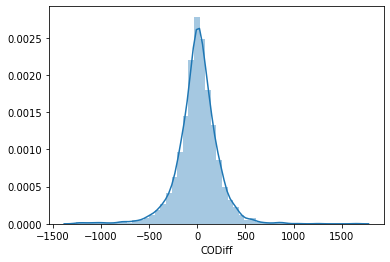

In [23]:
# 終値 - 始値 の分布
sns.distplot(df['CODiff'])

/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20184 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/leo/src/pyscript/traiding-sandbox/.venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20184 missing from current font.
  font.set_text(s, 0, flags=flags)


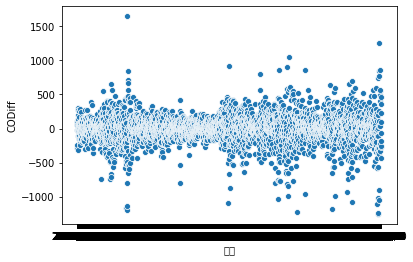

In [25]:
# 終値 - 始値 の時系列プロット
sns.scatterplot('日付', 'CODiff', data=df)

# 3. 大きく上がる日ほど始値からあまり下がらないという傾向があるか
- 右肩あがりだから、`終値 - 始値`が大きいほど、`安値 - 始値`も大きい、つまり寄り付きからの下落が小さいということがわかる。
- 今注目しているのは上がった日だけ（CODiff > 0の範囲だけ）だが、ここだけ見てもその傾向は明らか。
- 寄り付きから全く下がらなかったとき（始値 == 安値）のときは、y軸の値は0になるから上限が0で切れているのは仕方ない。
- 上昇日だけで見ると、始値から下落して安値をつけた場合、75％の日では下落率は0.5619%以内。だから、例えば損切を始値から-0.5619%のところに置いておけば、75％の上昇日では損切に引っかからずに終わりまでポジションを持ち続けられる。（あくまで過去データに基づく）
    - ちなみに0.5619%というのは、例えば平均価格が25,000円なら140.475円だから、これが損切ポイントとして妥当かどうかは不明
    - 50%の上昇日を捉えるなら、下落率は0.284%以内だから、71円。こちらのほうがだいぶ安全に見えるが、上昇日の半分は損切することになる。
    - 「デイトレード（オリバー・ベレス、グレッグ・カプラ）」によれば、著者は損切は確か**純資産の(?)**3%以内に置くと言っていたから、純資産ベースで考えたほうが良いかも。

71.0

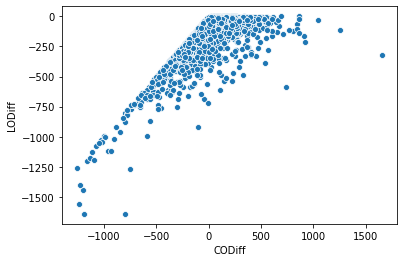

In [33]:
# x軸：終値 - 始値
# y軸：安値 - 始値
df['LODiff'] = df['安値'] - df['始値'] # Low - Open の Diff
sns.scatterplot('CODiff', 'LODiff', data=df)

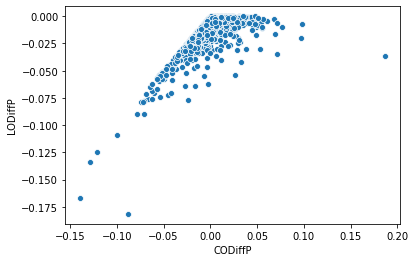

In [40]:
# x, y ともに価格ではなくその日の終値と始値の平均価格に対する割合で見てみる
df['OLAvg'] = (df['始値'] + df['終値']) / 2 # Open と Close の Average
df['CODiffP'] = df['CODiff'] / df['OLAvg'] # CODiff のOLAvgに対する Percentage
df['LODiffP'] = df['LODiff'] / df['OLAvg'] # LODiff のOLAvgに対する Percentage
sns.scatterplot('CODiffP', 'LODiffP', data=df)

分位数： 0.05   -0.012662
0.25   -0.005619
0.50   -0.002840
0.75   -0.001280
0.95   -0.000297
Name: LODiffP, dtype: float64


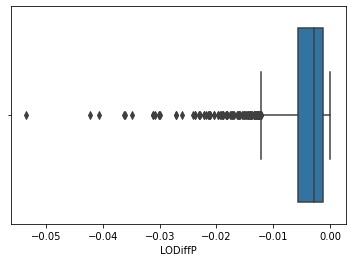

In [31]:
# 上昇日における安値の、始値からの下落率の分布
# 例えば0.25の行の値から、上昇日では始値から0.5619%以上下落した日は、全体の25％だったことわかる。
upDayDf = df[df['CODiff'] > 0]
sns.boxplot(upDayDf['LODiffP'])
print('分位数：', upDayDf['LODiffP'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 1 to 3375
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   日付       880 non-null    object 
 1   始値       880 non-null    int64  
 2   高値       880 non-null    int64  
 3   安値       880 non-null    int64  
 4   終値       880 non-null    int64  
 5   出来高      880 non-null    int64  
 6   CODiff   880 non-null    int64  
 7   LODiff   880 non-null    int64  
 8   OLAvg    880 non-null    float64
 9   CODiffP  880 non-null    float64
 10  LODiffP  880 non-null    float64
dtypes: float64(3), int64(7), object(1)
memory usage: 82.5+ KB


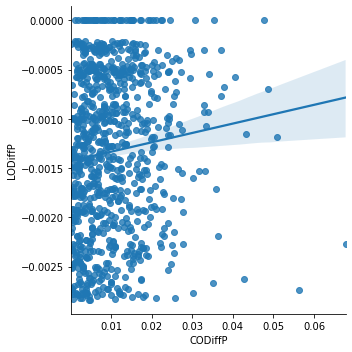

In [41]:
# 上の結果から、下落率の小さい50％の上昇日が含まれるデータで、改めて上昇率と下落率の関係をプロット
upDayDf50 = upDayDf[upDayDf['LODiffP'] >= -0.002840]
upDayDf50.info()
sns.lmplot('CODiffP', 'LODiffP', data=upDayDf50)

# 4. 下がる日については逆の傾向があるか
（要するに、大きく下がる日ほど、始値から高値までの上昇は小さいもしくは全く上昇しないという傾向があるか）
- 逆の傾向がみられた。つまり下落日については、大きく下落した日ほど、始値から高値までの上昇は小さかった。
- 売りで仕掛ける場合、例えば下落日全体の50％を捉えたいなら、損切価格は始値より0.2819%高いところに置いておけばよい。

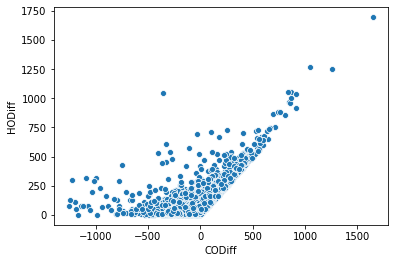

In [42]:
# x軸：終値 - 始値
# y軸：高値 - 始値
df['HODiff'] = df['高値'] - df['始値'] # High - Open の Diff
sns.scatterplot('CODiff', 'HODiff', data=df)

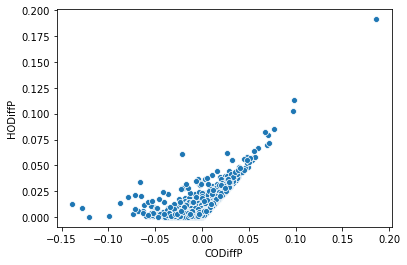

In [43]:
# x, y ともに価格ではなくその日の終値と始値の平均価格に対する割合で見てみる
df['HODiffP'] = df['HODiff'] / df['OLAvg'] # HODiff のOLAvgに対する Percentage
sns.scatterplot('CODiffP', 'HODiffP', data=df)

分位数： 0.05    0.000276
0.25    0.001171
0.50    0.002819
0.75    0.005521
0.95    0.012265
Name: HODiffP, dtype: float64


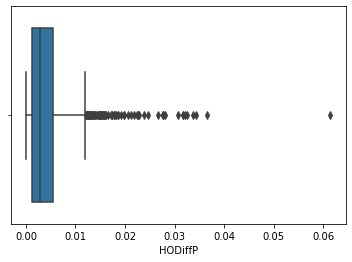

In [44]:
# 下落日における高値の、始値からの上昇率の分布
# 例えば0.75の行の値から、下落日では始値から0.5521%以上上昇した日は、全体の25％だったことわかる。
downDayDf = df[df['CODiff'] < 0]
sns.boxplot(downDayDf['HODiffP'])
print('分位数：', downDayDf['HODiffP'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# 5. 上がる日において、高値 - 終値の分布を可視化して、差が大きい日がどの程度あるか確認
（その日の上昇率と、高値 - 終値 の関係を可視化）
- グラフが右肩下がりになっていることから、トレーリングストップを置いたほうが良いことは明らか
- ただし、このグラフからは判断できないことがある。
    - もし、大きく上昇する日でも、大きな上昇と大きな下落を繰り返しながら上がっていくとしたら、トレーリングストップを最初の高値に近いところに置いてしまうと最初の下落の途中で手仕舞ってうことになる、という可能性。これがどれくらい起きるのかは分足データで解析が必要。

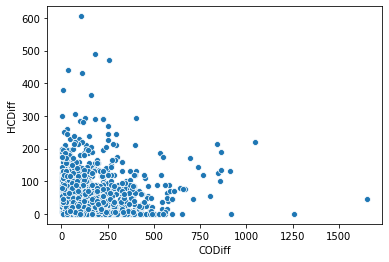

In [47]:
df['HCDiff'] = df['高値'] - df['終値'] # High - Close の Diff
upDayDf = df[df['CODiff'] > 0]
sns.scatterplot('CODiff', 'HCDiff', data=upDayDf)